## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [10]:
# !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

# # Use the direct link to download the file
# !wget --no-check-certificate 'https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO' -O coco_imgs.npy
# # Check if the file is downloaded
# !ls
from google.colab import drive

drive.mount('/content/drive')
filepath="/content/drive/MyDrive/coco_captions.npy"
caption_embeddings = np.load(filepath)
file_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

# # Use the direct link to download the file
# !wget --no-check-certificate 'https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW' -O coco_captions.npy
# # Check if the file is downloaded
# !ls


Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [6]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [55]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [56]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [54]:
# cap_path = '/content/coco_captions.npy'
# caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [53]:
# img_path = '/content/coco_imgs.npy'
# image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


100%|██████████| 40504/40504 [06:52<00:00, 98.12it/s]


Calculation Done!!


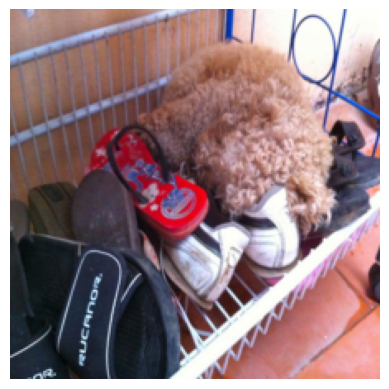

Ground Truth: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']
Predicted: The two dogs are sitting on a chair.


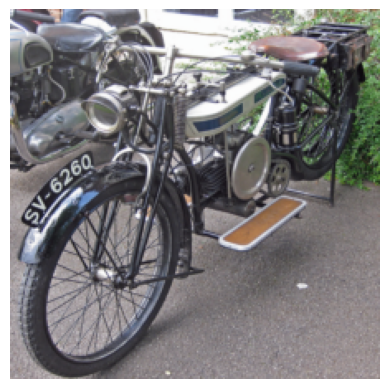

Ground Truth: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted:  A motorcycle parked in front of a crowd of people.


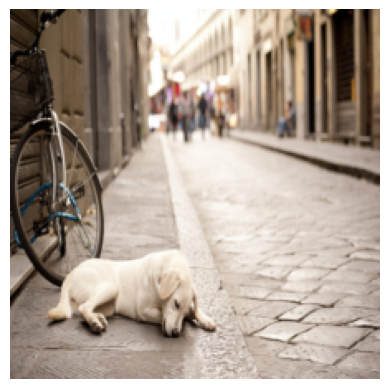

Ground Truth: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']
Predicted: A brown dog is laying by a bench.


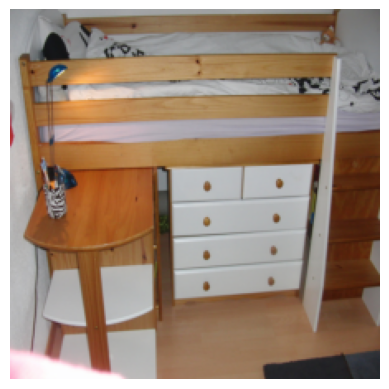

Ground Truth: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted: A bedroom with a bed, desk and shelving unit. 


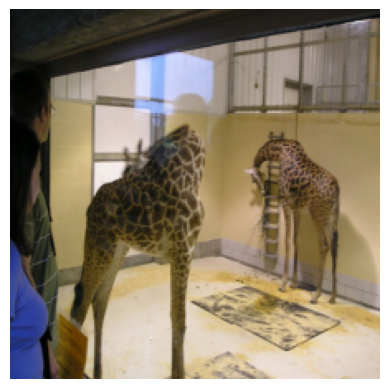

Ground Truth: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']
Predicted: A group of giraffe standing next to each other.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Accuracy: 0.0723923250317784


In [78]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import faiss
import numpy as np


def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def get_cosine_similarity(query_vector, caption_embeddings, indices):
    #Normalizing
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    # Computing cosine similarity using normalized embeddings
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    # Finding the index with the maximum similarity
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j

    # Getting the corresponding caption
    closest_caption = captions[max_index][cap_ind]

    return closest_caption

dim = image_embeddings.shape[1]

# Creating an index for fast nearest neighbor search using Faiss
index = faiss.IndexFlatIP(dim)
index.add(image_embeddings.astype('float32'))

pred_captions_list = []

# Iterating over each image and finding k-nearest neighbors
for i in tqdm(range(len(coco_dset))):
# for i in tqdm(range(5)):
    #current image
    img = image_embeddings[i:i+1].astype('float32')
    k = 5
    D, I = index.search(img, k + 1)
    # Excluding the query image itself
    D = D[0][1:]
    I = I[0][1:]

    query_vector = np.zeros_like(image_embeddings[i])
    for j in I:
        similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
        for l in range(5):
            query_vector += similarity_scores * caption_embeddings[j][l]

    # Normalizing by the number of nearest neighbors
    query_vector /= (5 * k)
    # Getting the closest caption text
    closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
    pred_captions_list.append(closest_caption_text)


# Displaying the first five images and their captions
num_visualizations = 5
for i in range(num_visualizations):
    img, target = coco_dset[i]
    display_image(img)
    print(f"Ground Truth: {captions[i]}\nPredicted: {pred_captions_list[i]}")


accuracy_value = accuracy_v2(pred_captions_list, captions_np)
print(f"Accuracy: {accuracy_value}")


### Checking for multiple k(using IndexFlatIP, k=2)

100%|██████████| 40504/40504 [06:44<00:00, 100.02it/s]


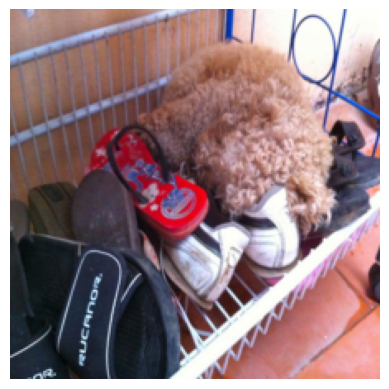

Ground Truth: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']
Predicted: A dog laying in a doggy bed with a cat.


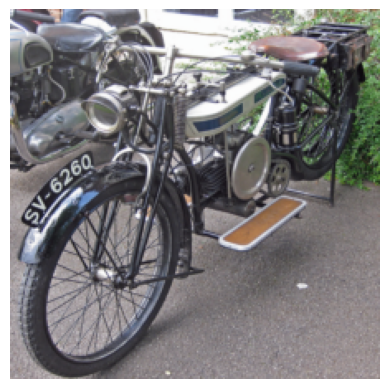

Ground Truth: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted: a close up of a motorcycle parked near other cars


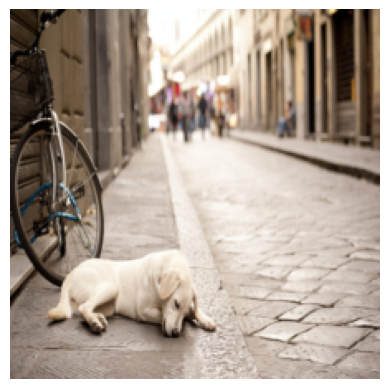

Ground Truth: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']
Predicted: A brown dog is laying by a bench.


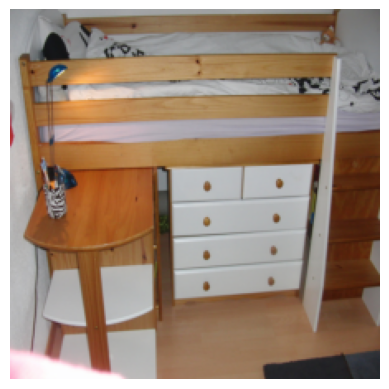

Ground Truth: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted: A close view of kitchen cabinets and drawers.


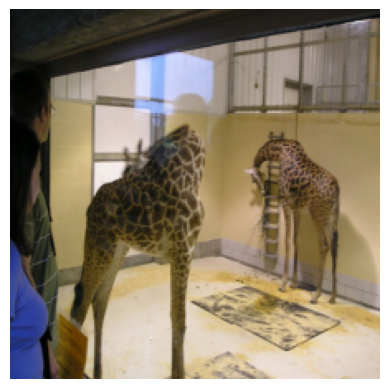

Ground Truth: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']
Predicted: A couple of giraffe standing next to each other.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Accuracy: 0.06531265293085392


In [94]:
def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def get_cosine_similarity(query_vector, caption_embeddings, indices):
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j


    closest_caption = captions[max_index][cap_ind]

    return closest_caption


dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(image_embeddings.astype('float32'))

pred_captions_list = []

for i in tqdm(range(len(coco_dset))):
# for i in tqdm(range(5)):
    img = image_embeddings[i:i+1].astype('float32')

    k = 2
    D, I = index.search(img, k + 1)
    D = D[0][1:]
    I = I[0][1:]
    query_vector = np.zeros_like(image_embeddings[i])

    for j in I:
        similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
        for l in range(5):
            query_vector += similarity_scores * caption_embeddings[j][l]

    query_vector /= (5 * k)


    closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
    pred_captions_list.append(closest_caption_text)

num_visualizations = 5
for i in range(num_visualizations):
    img, target = coco_dset[i]
    display_image(img)
    print(f"Ground Truth: {captions[i]}\nPredicted: {pred_captions_list[i]}")

accuracy_value = accuracy_v2(pred_captions_list, captions_np)
print(f"Accuracy: {accuracy_value}")


Checking for multiple k(using IndexFlatIP, k=7)

100%|██████████| 40504/40504 [07:24<00:00, 91.10it/s] 


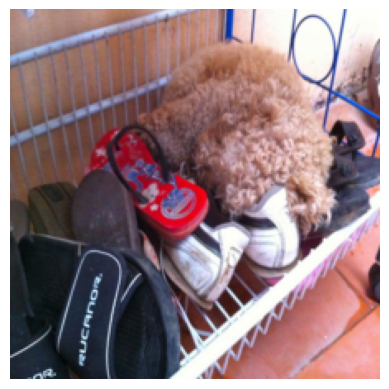

Ground Truth: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']
Predicted: The two dogs are sitting on a chair.


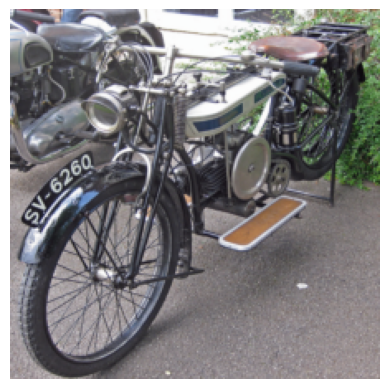

Ground Truth: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted: There is a group of motorcycles that are parked together.


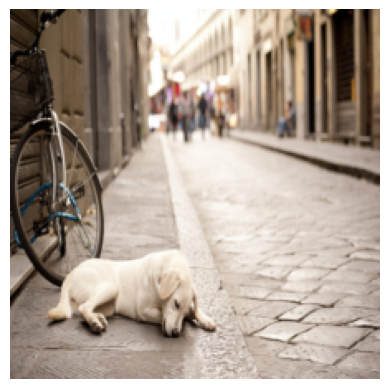

Ground Truth: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']
Predicted: A dog standing on a bench during the day.


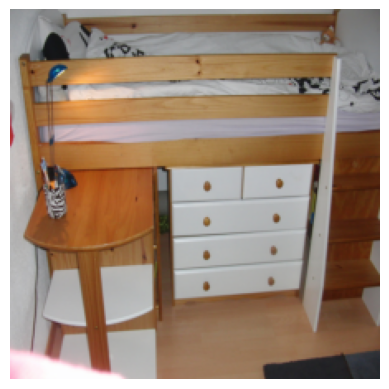

Ground Truth: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted: A bedroom with a bed, desk and shelving unit. 


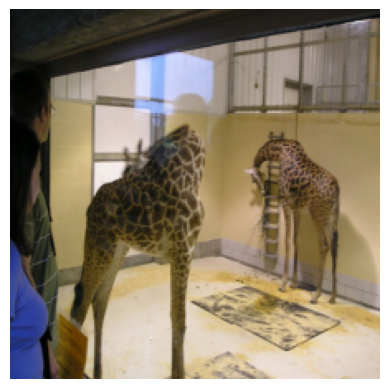

Ground Truth: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']
Predicted: A group of giraffe standing next to each other.
Accuracy: 0.07343227358740796


In [95]:
def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def get_cosine_similarity(query_vector, caption_embeddings, indices):
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j

    closest_caption = captions[max_index][cap_ind]
    return closest_caption


dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(image_embeddings.astype('float32'))

pred_captions_list = []

for i in tqdm(range(len(coco_dset))):
# for i in tqdm(range(5)):
    img = image_embeddings[i:i+1].astype('float32')
    k = 7
    D, I = index.search(img, k + 1)
    D = D[0][1:]
    I = I[0][1:]
    query_vector = np.zeros_like(image_embeddings[i])

    for j in I:
        similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
        for l in range(5):
            query_vector += similarity_scores * caption_embeddings[j][l]
    query_vector /= (5 * k)
    closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
    pred_captions_list.append(closest_caption_text)

num_visualizations = 5
for i in range(num_visualizations):
    img, target = coco_dset[i]
    display_image(img)
    print(f"Ground Truth: {captions[i]}\nPredicted: {pred_captions_list[i]}")

accuracy_value = accuracy_v2(pred_captions_list, captions_np)
print(f"Accuracy: {accuracy_value}")


## Using IndexFlatL2


100%|██████████| 40504/40504 [07:33<00:00, 89.31it/s]


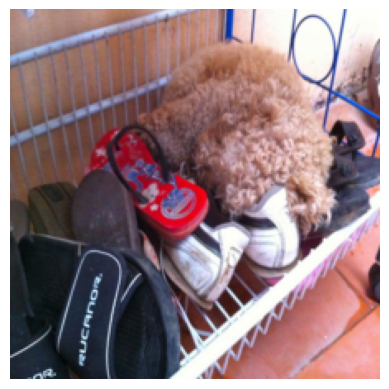

Ground Truth: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']
Predicted: The two dogs are sitting on a chair.


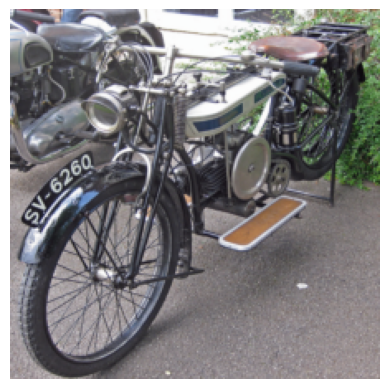

Ground Truth: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted:  A motorcycle parked in front of a crowd of people.


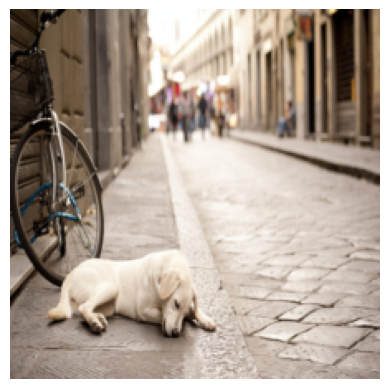

Ground Truth: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']
Predicted: A brown dog is laying by a bench.


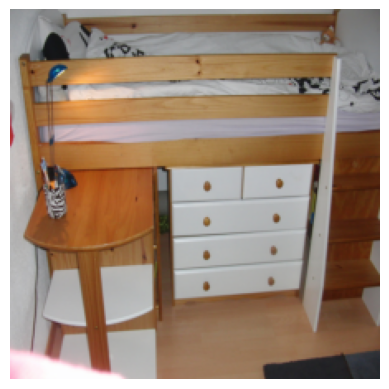

Ground Truth: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted: A bedroom with a bed, desk and shelving unit. 


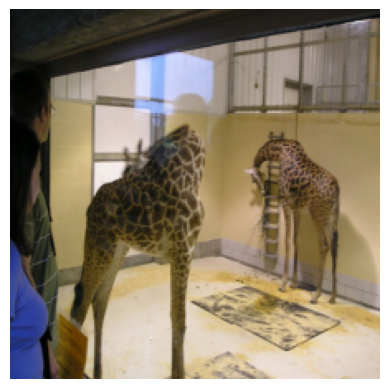

Ground Truth: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']
Predicted: A group of giraffe standing next to each other.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Accuracy: 0.07252093419068131


In [96]:
def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def get_cosine_similarity(query_vector, caption_embeddings, indices):
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j
    closest_caption = captions[max_index][cap_ind]
    return closest_caption


dim = image_embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(image_embeddings.astype('float32'))

pred_captions_list = []


for i in tqdm(range(len(coco_dset))):
# for i in tqdm(range(5)):
    img = image_embeddings[i:i+1].astype('float32')
    k = 5
    D, I = index.search(img, k + 1)
    D = D[0][1:]
    I = I[0][1:]
    query_vector = np.zeros_like(image_embeddings[i])

    for j in I:
        similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
        for l in range(5):
            query_vector += similarity_scores * caption_embeddings[j][l]

    query_vector /= (5 * k)
    closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
    pred_captions_list.append(closest_caption_text)


num_visualizations = 5
for i in range(num_visualizations):
    img, target = coco_dset[i]
    display_image(img)
    print(f"Ground Truth: {captions[i]}\nPredicted: {pred_captions_list[i]}")

accuracy_value = accuracy_v2(pred_captions_list, captions_np)
print(f"Accuracy: {accuracy_value}")


## Using IndexIVFFlat

100%|██████████| 40504/40504 [01:28<00:00, 459.29it/s]


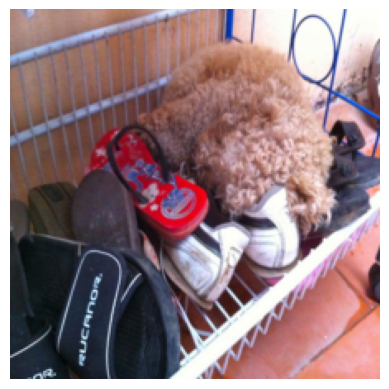

Ground Truth: ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them']
Predicted: A dog is laying down on a bed.


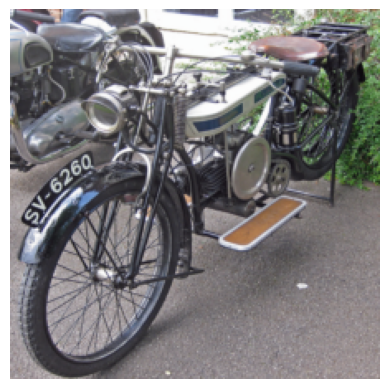

Ground Truth: ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. ']
Predicted: Several motorcycles are parked together as people stand around them. 


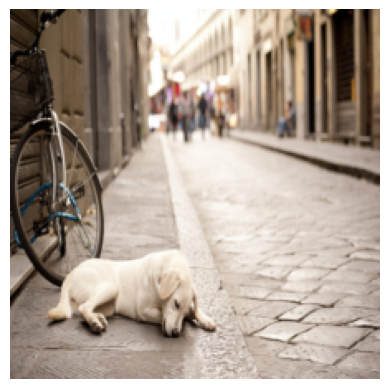

Ground Truth: ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.']
Predicted: A brown dog is laying by a bench.


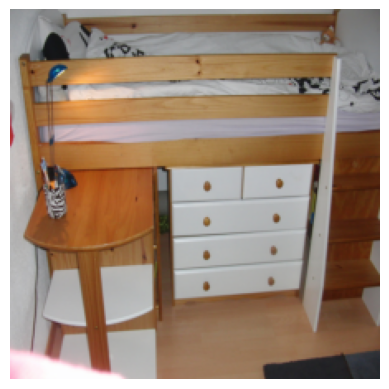

Ground Truth: ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']
Predicted: A bedroom with a bed, desk and shelving unit. 


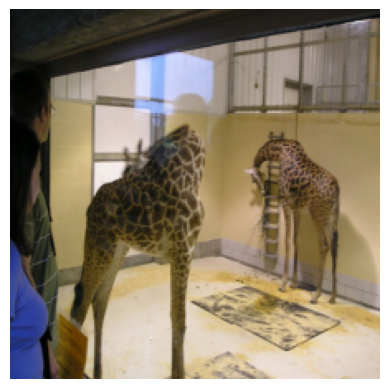

Ground Truth: ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']
Predicted: A group of giraffe standing next to each other.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Accuracy: 0.06984106533864244


In [103]:
def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def get_cosine_similarity(query_vector, caption_embeddings, indices):
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j

    closest_caption = captions[max_index][cap_ind]
    return closest_caption

dim = image_embeddings.shape[1]

nlist = 7
quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantizer, dim, nlist)
index.train(image_embeddings.astype('float32'))
index.add(image_embeddings.astype('float32'))

pred_captions_list = []

for i in tqdm(range(len(coco_dset))):
# for i in tqdm(range(5)):
    img = image_embeddings[i:i+1].astype('float32')
    k = 5
    D, I = index.search(img, k + 1)
    D = D[0][1:]
    I = I[0][1:]

    query_vector = np.zeros_like(image_embeddings[i])

    for j in I:
        similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
        for l in range(5):
            query_vector += similarity_scores * caption_embeddings[j][l]

    query_vector /= (5 * k)
    closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
    pred_captions_list.append(closest_caption_text)


num_visualizations = 5
for i in range(num_visualizations):
    img, target = coco_dset[i]
    display_image(img)
    print(f"Ground Truth: {captions[i]}\nPredicted: {pred_captions_list[i]}")

accuracy_value = accuracy_v2(pred_captions_list, captions_np)
print(f"Accuracy: {accuracy_value}")


## Using IndexHNSWFlat(for k=1 to 15)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Accuracy of k=1: 0.05773186186943897
Accuracy of k=2: 0.06533212872836354
Accuracy of k=3: 0.06869254806351575
Accuracy of k=4: 0.07027020160466001
Accuracy of k=5: 0.072443488788407
Accuracy of k=6: 0.07298379640408452
Accuracy of k=7: 0.0734387492996063
Accuracy of k=8: 0.0737362923472283
Accuracy of k=9: 0.07231586008048158
Accuracy of k=10: 0.07295673687444237
Accuracy of k=11: 0.07404478292884158
Accuracy of k=12: 0.07271373047340819
Accuracy of k=13: 0.07334434539839448
Accuracy of k=14: 0.07268322861056017
Accuracy of k=15: 0.07214597937507182


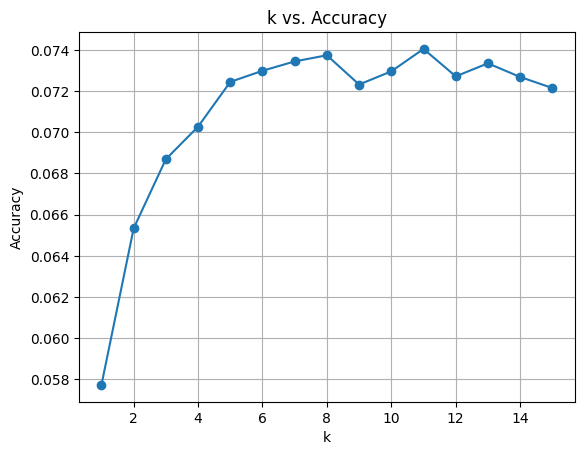

Accuracy at k=5 is:0.072443488788407


In [108]:
def display_image(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def get_cosine_similarity(query_vector, caption_embeddings, indices):
    query_vector_normalized = query_vector / np.linalg.norm(query_vector)
    caption_embeddings_normalized = caption_embeddings / np.linalg.norm(caption_embeddings, axis=1)[:, np.newaxis]
    similarity_scores = np.dot(caption_embeddings_normalized, query_vector_normalized)
    return similarity_scores

def compute_cosine_similarity(vector1, vector2):
    norm_vector1 = vector1 / np.linalg.norm(vector1)
    norm_vector2 = vector2 / np.linalg.norm(vector2)
    similarity = np.dot(norm_vector1, norm_vector2)
    return similarity


def get_closest_caption(query_vector, caption_embeddings, captions, k):
    max_index = -1
    max_similarity = -1
    cap_ind=-1

    for i in I:
      for j in range(5):
        similarity_scores = compute_cosine_similarity(query_vector, caption_embeddings[i][j])
        if similarity_scores > max_similarity:
          max_similarity = similarity_scores
          max_index = i
          cap_ind=j

    closest_caption = captions[max_index][cap_ind]
    return closest_caption


dim = image_embeddings.shape[1]
index = faiss.IndexHNSWFlat(dim,32)
index.add(image_embeddings)

acc=[]
# li=[2,3,4,5,6]
for k in range(1,16):
  pred_captions_list = []
  for i in range(len(coco_dset)):
  # for i in tqdm(range(5)):
      img = image_embeddings[i:i+1].astype('float32')
      D, I = index.search(img, k + 1)
      D = D[0][1:]
      I = I[0][1:]
      query_vector = np.zeros_like(image_embeddings[i])

      for j in I:
          similarity_scores = get_cosine_similarity(image_embeddings[j], img, range(5))
          for l in range(5):
              query_vector += similarity_scores * caption_embeddings[j][l]

      query_vector /= (5 * k)
      closest_caption_text = get_closest_caption(query_vector, caption_embeddings, captions, I)
      pred_captions_list.append(closest_caption_text)


  accuracy_value = accuracy_v2(pred_captions_list, captions_np)
  print(f"Accuracy of k={k}: {accuracy_value}")
  acc.append(accuracy_value)


k_values = list(range(1, 16))
plt.plot(k_values, acc, marker='o')
plt.title('k vs. Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
print(f'Accuracy at k=5 is:{acc[4]}')

In [44]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

| Faiss Index | Bleu score | k |
|-------------|------------|---|
| IndexFlatIP     | 0.0723923250317784       | 5 |
| IndexFlatIP     | 0.06531265293085392      | 2 |
| IndexFlatIP     | 0.07343227358740796      | 7 |
| IndexFlatL2     | 0.07252093419068131      | 5 |
| IndexFlatIVFFlat     | 0.06984106533864244       | 5 |
| IndexHNSWFlat       | 0.072443488788407        | 5 |
